In [22]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [23]:
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
wildfire-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [24]:
import zipfile
zip_ref = zipfile.ZipFile('/content/wildfire-prediction-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [25]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [26]:
from struct import unpack
from tqdm import tqdm
import os

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while True:
            marker, = unpack(">H", data[0:2])
            if marker == 0xffd8:  # Start of Image
                data = data[2:]
            elif marker == 0xffd9:  # End of Image
                return
            elif marker == 0xffda:  # Start of Scan
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data) == 0:
                break

def check_images(directory):
    images = [img for img in os.listdir(directory) if img.lower().endswith('.jpg') or img.lower().endswith('.jpeg')]
    bads = []

    for img in tqdm(images):
        image_path = os.path.join(directory, img)
        image = JPEG(image_path)
        try:
            image.decode()
        except:
            bads.append(img)

    for name in bads:
        os.remove(os.path.join(directory, name))
        print(f"Removed bad image: {name}")

# Usage
train_noWildFire = '/content/train/nowildfire'
check_images(train_noWildFire)
train_WildFire = '/content/train/wildfire'
check_images(train_WildFire)
test_noWildFire ='/content/test/nowildfire'
check_images(test_noWildFire)
test_WildFire='/content/test/wildfire'
check_images(test_WildFire)
valid_noWildFire='/content/valid/nowildfire'
check_images(valid_noWildFire)
valid_WildFire='/content/valid/wildfire'
check_images(valid_WildFire)

100%|██████████| 14500/14500 [00:00<00:00, 17684.88it/s]


Removed bad image: -114.152378,51.027198.jpg


100%|██████████| 3480/3480 [00:00<00:00, 16452.87it/s]


Removed bad image: -73.15884,46.38819.jpg


100%|██████████| 3480/3480 [00:00<00:00, 17959.16it/s]


In [27]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/valid',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)
test_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 30249 files belonging to 2 classes.
Found 6300 files belonging to 2 classes.
Found 6299 files belonging to 2 classes.


In [28]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)
test_ds = test_ds.map(process)

In [29]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_4 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                      

In [31]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
946/946 [==============================] - 100s 102ms/step - loss: 1.1053 - accuracy: 0.8837 - val_loss: 0.1983 - val_accuracy: 0.9343
Epoch 2/10
946/946 [==============================] - 97s 102ms/step - loss: 0.2150 - accuracy: 0.9224 - val_loss: 0.1535 - val_accuracy: 0.9441
Epoch 3/10
946/946 [==============================] - 95s 100ms/step - loss: 0.1724 - accuracy: 0.9359 - val_loss: 0.1271 - val_accuracy: 0.9511
Epoch 4/10
946/946 [==============================] - 97s 101ms/step - loss: 0.1454 - accuracy: 0.9468 - val_loss: 0.1787 - val_accuracy: 0.9281
Epoch 5/10
946/946 [==============================] - 96s 101ms/step - loss: 0.1835 - accuracy: 0.9364 - val_loss: 0.1486 - val_accuracy: 0.9427
Epoch 6/10
946/946 [==============================] - 96s 101ms/step - loss: 0.1326 - accuracy: 0.9498 - val_loss: 0.1353 - val_accuracy: 0.9471
Epoch 7/10
946/946 [==============================] - 96s 101ms/step - loss: 0.1092 - accuracy: 0.9595 - val_loss: 0.1930 - val_a

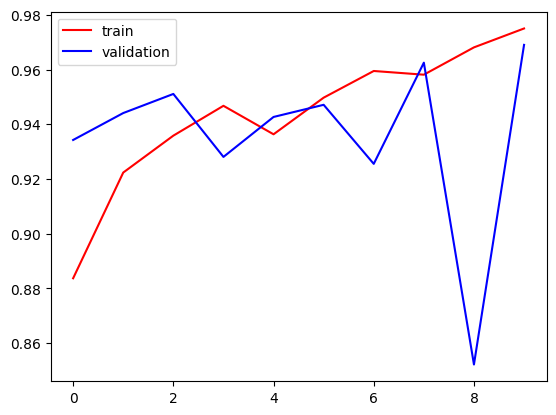

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

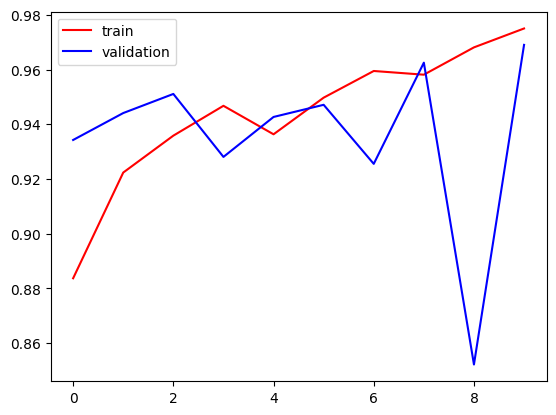

In [34]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

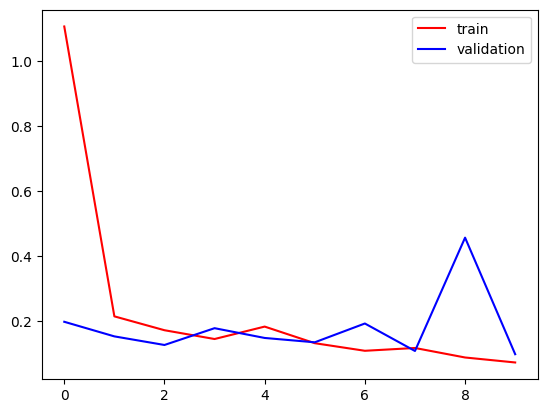

In [35]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

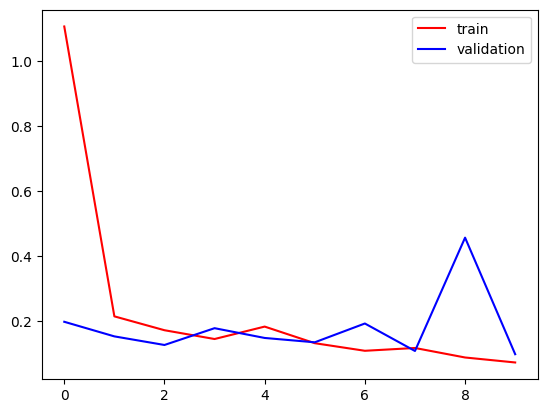

In [36]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [37]:
import cv2

In [40]:
test_img = cv2.imread('/content/-59.03238,51.85132.jpg')

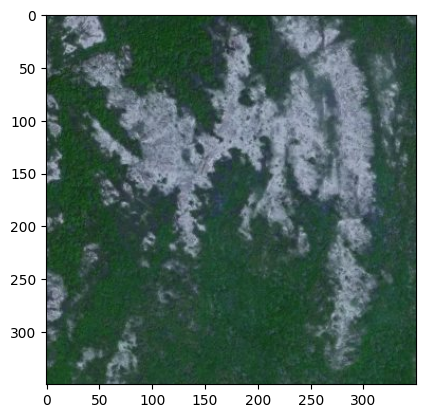

In [41]:
plt.imshow(test_img)

In [42]:
test_img.shape

(350, 350, 3)

In [45]:
test_img = cv2.resize(test_img,(256,256))

In [46]:
test_input = test_img.reshape((1,256,256,3))

In [47]:
model.predict(test_input)
# 1 means fire

1/1 [==============================] - 0s 425ms/step


array([[1.]], dtype=float32)